# APONTIS Pharma - Krankenhäuser & Rehakliniken als Startpunkte der Patient:innenreise aufgrund eines Arztbriefs

# Executive Summary

Basierend auf den zur Verfügung stehenden Informationen (OPS-301 noch ausstehend aufgrund fehlender Information) zeigen die folgenden Krankenhäuser ein besonders hohes Potenzial als Ausgangspunkt einer Patient:innenreise mit dem APONTIS Präparat Iltria.

Antibiotikum Hersteller
Tuberkulose
Infektionen nach Protheseneinsetzen
welche KHs machen Prothesen?
Hüft und Knie OPs 5-6 % sind infektiös
rivampicin
Rifampicin
Chrurige und Orthopäden
Durchschnitt über die letzten Jahre

https://www.miaglossa.com/
Video Calls gbaud

# Zielsetzung der Analyse

In dieser Analyse sollen umsatz- und außendienstrelevante Krankenhäuser, wie z.B. Rehakliniken, Neurologische Rehabilitationseinrichtungen oder auch geriatrische Einrichtung, in Deutschland identifiziert werden, die ihren Patient:innen einen möglicherweise einen Arztbrief ausstellen, der die Gabe eines APONTIS Kombinationspräparats nahegelegt. Im Speziellen sollen mögliche Außendienst- und Marketingziele für das Produkt Iltria identifiziert werden, das in der Sekundärprophylaxe nach kardiovaskulären Events (z.B. Herzinfarkt oder Schlaganfall) eingesetzt wird. 
Das Wissen über signifikante Patient:innenströme mit entsprechender Symptomatik in einem Haus ermöglicht es den APONTIS Marketing- und Außendienstexpert:innen, mit den behandelnden Ärzt:innen frühzeitig ins Gespräch zu kommen, um die Behandlung betroffener Patient:innen frühzeitig zu begleiten. Somit können Patient:innen bereits zu Beginn ihrer Patientenreise von den Vorzüge der APONTIS Kombipräparate profitieren.
Grundlage dieser Analyse sind die vom Gemeinsamen Bundesausschuss veröffentlichten Qualitätsberichte der Krankenhäuser.

Folgende Aspekte sollen in dieser Analyse untersucht werden werden:

1. Direkte Identifizierung von Reha-Einrichtungen und/oder Geriatrien **basierend auf Identifikationsmerkmalen der Qualitätsberichte**
2. Identifizierung von Reha-Kliniken, Neurologischen Rehabilitationseinrichtungen und Geriatrien **anhand ihrer Fachabteilungen**
3. Identifizierung von Krankenhäuser, Reha-Einrichtungen Neurologischen Rehabilitationseinrichtungen und Geriatrien anhand der für das **APONTIS Iltria relevanten ICD-10 Fälle**
4. Identifizierung von Krankenhäuser, Reha-Einrichtungen Neurologischen Rehabilitationseinrichtungen und Geriatrien anhand der für das **APONTIS Iltria relevanten OPS-301 Codes** (Gabe eigener Produkte oder Produkte des Wettbewerbs)
5. Kombinierende Analyse über die geeignetsten Messgrößen für ein abschließende Empfehlung

## Technisches Setup: Python Module & Datenbankverbindung

Einrichtung von Python Paketen und der Datenbankverbindung -- rein technisch; kein analytischer Mehrwert und deshalb ausgeblendet

In [20]:
import html
import sqlite3
import pandas as pd
# import pydeck as pdk
# import plotly.express as px
from itertools import chain

In [21]:
DB_FILE='/Users/tobias.setzer/python_bin/busy-beaver/all_data.db'

In [22]:
def get_db_connection() -> sqlite3.Connection:
    con = sqlite3.connect(DB_FILE, check_same_thread=False)
    return con

In [ ]:
def run_sql(stmt: str) -> pd.DataFrame:
    con = get_db_connection()
    return pd.read_sql_query(stmt, con=con)

In [25]:
df = run_sql(       
            f"""SELECT ID, Code, SuperClass, List_SubClass, Kind, Preferred, List_Notes, List_Exclusions, List_Inclusions
FROM ICD10;"""
        )
df.head()

,ID,Code,SuperClass,List_SubClass,Kind,Preferred,List_Notes,List_Exclusions,List_Inclusions
0,0,I,NaN,"""A00-A09"",""A15-A19"",""A20-A28"",""A30-A49"",""A50-A64"",""A65-A69"",""A70-A74"",""A75-A79"",""A80-A89"",""A92-A...",chapter,Bestimmte infektiöse und parasitäre Krankheiten,NaN,"""Keimträger oder -ausscheider, einschließlich Verdachtsfällen "",""Z22.-"",""Bestimmte lokalisierte ...","""Krankheiten, die allgemein als ansteckend oder übertragbar anerkannt sind"""
1,1,A00-A09,I,"""A00"",""A01"",""A02"",""A03"",""A04"",""A05"",""A06"",""A07"",""A08"",""A09""",block,Infektiöse Darmkrankheiten,NaN,NaN,NaN
2,2,A00,A00-A09,"""A00.0"",""A00.1"",""A00.9""",category,Cholera,NaN,NaN,NaN
3,3,A00.0,A00,NaN,category,"Cholera durch Vibrio cholerae O:1, Biovar cholerae",NaN,NaN,"""Klassische Cholera"""
4,4,A00.1,A00,NaN,category,"Cholera durch Vibrio cholerae O:1, Biovar eltor",NaN,NaN,"""El-Tor-Cholera"""


In [ ]:
### [ICD-10 QUERY] This is the most generic query which allows to append data regardless of ICD-10 or OPS-301 codes --> hospitals are only identified by their IK and name; any additional analyses happen at a later point
def get_sum_icd10_kh(columns: str = "", where: str = "") -> pd.DataFrame:
    df = run_sql(       
            f"""SELECT
        Berichtsjahr,
        IK,
        Name,
        SUM(Fallzahl) AS Fallzahl_Total,
        AVG(DISTINCT geo_Lat) AS Latitude,
        AVG(DISTINCT geo_Lon) AS Longitude,
        {columns}
    FROM
        VIEW_Krankenhaus_Hauptdiagnosen
    {where}
    GROUP BY
        Berichtsjahr,
        IK
    ORDER BY
        Fallzahl_Total DESC
    ;"""
        )
    df["Fallzahl_Total_Text"] = (
        df["Fallzahl_Total"].fillna(-1).astype(int).astype(str).replace("-1", "< 4")
    )
    df["Fallzahl_Total"].fillna(0, inplace=True)
    return df

## Analyse

In [14]:
icd_apontis = "\
'I21.1', 'I21.2', 'I21.3', 'I21.4', 'I21.9', 'I22', 'I22.0', 'I22.1', 'I22.8', 'I22.9', 'I23', 'I23.0',\
'I23.1', 'I23.2', 'I23.3', 'I23.4', 'I23.5', 'I23.6', 'I23.8', 'I24.0', 'I24.1', 'I63', 'I63.0', 'I63.1', 'I63.2', 'I63.3', 'I63.4',\
'I63.5', 'I63.6', 'I63.8', 'I63.9', 'I64', 'I69', 'I69.0', 'I69.1', 'I69.2', 'I69.3', 'I69.4'"

### Direkte Identifizierung von Reha-Einrichtungen und/oder Geriatrien basierend auf Identifikationsmerkmalen der Qualitätsberichte

Es wird in der neunstelligen Institutionskennzeichnung (IK) nach Hinweisen auf Rehaeinrichtungen o.ä. gesucht. **Die ersten beiden Stellen der neunstelligen IK geben Auskunft**, über die Art der Einrichtung. Für nähere Informationen s. https://www.gkv-datenaustausch.de/media/dokumente/leistungserbringer_1/sonstige_leistungserbringer/GR-IK-2023-11.pdf

In [15]:
def get_distinct_kh_type(where: str = "") -> pd.DataFrame:
    df = run_sql(       
            f"""SELECT DISTINCT
        SUBSTR(IK, 0, 3) AS KH_Type
    FROM
        VIEW_Krankenhaus_Hauptdiagnosen
    {where}
    ORDER BY
    KH_Type DESC
    ;"""
    )
    return df
kh_type = get_distinct_kh_type(where=f"""WHERE Berichtsjahr = 2022""")
kh_type

DatabaseError: Execution failed on sql 'SELECT DISTINCT
        SUBSTR(IK, 0, 3) AS KH_Type
    FROM
        VIEW_Krankenhaus_Hauptdiagnosen
    WHERE Berichtsjahr = 2022
    ORDER BY
    KH_Type DESC
    ;': no such table: main.Adresse

Es wurden zwei Krankenhaus-Typen gefunden:

- **51** -- Alten- und Pflegeheime, Tages-und Kurzzeitpflege, Sonderschulheime, Sozial-therapeutische Zentren
- **26** -- Krankenhäuser, Krankenhausapotheken

Die entsprechenden Häuser, die unter der Ziffer 51 gefunden wurden lauten

In [16]:
pd.options.display.max_colwidth = 100
def get_khs_w_type(where: str = "") -> pd.DataFrame:
    df = run_sql(       
            f"""SELECT DISTINCT
        SUBSTR(IK, 0, 3) AS KH_Type,
        Name
    FROM
        VIEW_Krankenhaus_Hauptdiagnosen
    {where}
    ORDER BY
    KH_Type DESC
    ;"""
    )
    return df
# fa = get_fa(where=f"""WHERE Berichtsjahr = 2022""")
kh = get_khs_w_type(where=f"""WHERE (Berichtsjahr = 2022) AND (KH_Type in ('51', '57', '59', '27'))""")
kh


DatabaseError: Execution failed on sql 'SELECT DISTINCT
        SUBSTR(IK, 0, 3) AS KH_Type,
        Name
    FROM
        VIEW_Krankenhaus_Hauptdiagnosen
    WHERE (Berichtsjahr = 2022) AND (KH_Type in ('51', '57', '59', '27'))
    ORDER BY
    KH_Type DESC
    ;': no such table: main.Adresse

Bereits die Kliniknamen der 13 gefundenen Häuser weisen daraufhin, dass die Anzahl der relevanten Einrichtungen klein ist und viele Häuser einen Schwerpunkt in der Kinder- und Jugendheilkunde haben.

Eine abschließende Filterung auf Einrichtungen mit Iltria-relevanten ICD-10 Fällen ist unten aufgeführt. In der Spalte "Fallzahl_Total_Text" können die Fallzahlen für alle Iltria-relevanten ICD-10 Codes gefunden werden.

In [19]:
fa_icd = get_sum_icd10_kh(columns="Postleitzahl,\n geo_Bundesland", where=f"""WHERE (Berichtsjahr = 2022) AND (SUBSTR(IK, 0, 3) in ('51', '57', '59', '27')) AND (ICD_10 in ({icd_apontis}))""")
fa_icd

DatabaseError: Execution failed on sql 'SELECT
        Berichtsjahr,
        IK,
        Name,
        SUM(Fallzahl) AS Fallzahl_Total,
        AVG(DISTINCT geo_Lat) AS Latitude,
        AVG(DISTINCT geo_Lon) AS Longitude,
        Postleitzahl,
 geo_Bundesland
    FROM
        VIEW_Krankenhaus_Hauptdiagnosen
    WHERE (Berichtsjahr = 2022) AND (SUBSTR(IK, 0, 3) in ('51', '57', '59', '27')) AND (ICD_10 in ('I21.1', 'I21.2', 'I21.3', 'I21.4', 'I21.9', 'I22', 'I22.0', 'I22.1', 'I22.8', 'I22.9', 'I23', 'I23.0','I23.1', 'I23.2', 'I23.3', 'I23.4', 'I23.5', 'I23.6', 'I23.8', 'I24.0', 'I24.1', 'I63', 'I63.0', 'I63.1', 'I63.2', 'I63.3', 'I63.4','I63.5', 'I63.6', 'I63.8', 'I63.9', 'I64', 'I69', 'I69.0', 'I69.1', 'I69.2', 'I69.3', 'I69.4'))
    GROUP BY
        Berichtsjahr,
        IK
    ORDER BY
        Fallzahl_Total DESC
    ;': no such table: main.Adresse

In [18]:
import plotly.express as px
fig1 = px.bar(fa_icd, x='Name', y='Fallzahl_Total')
fig1.show()

ModuleNotFoundError: No module named 'plotly'

**Zusammenfassend ist zu erkennen, dass eine Suche auf Grundlage der Institutionskennzeichnung wenig Erkenntnisgewinn bringt.**

### Betrachtung nach Fachabteilungen

In diesem Abschnitt soll eine Untersuchung nach Fachabteilungen und deren Verteilung auf die Krankenhäuser in Deutschland angestellt werden. Zu diesem Zweck wird per "regular expressions" nach Abteilungen mit Bezug zu "Rehabilitation", "Neurologischer Rehabilitation", "Geriatrischer Rehabilitation" und "Geriatrie" gesucht.

In [99]:
def get_fa_kh() -> pd.DataFrame:
    df = run_sql(       
            f"""SELECT DISTINCT
    IK,
    Name AS KH_Name,
    Strasse,
   	Hausnummer,
   	Postleitzahl,
   	geo_Bundesland AS Bundesland,
   	geo_Lat AS Latitude,
   	geo_Lon AS Longitude,
    Vollstationaere_Fallzahl_OE AS FA_Vollstationaere_Fallzahl,
    Name_OE AS FA_Name,
    CASE	    
	    WHEN Name_OE like '%neurolog%reha%' then 'Neurologische Rehabilitation'
	    WHEN Name_OE like '%geriatri%reha%' then 'Geriatrische Rehabilitation'
    	WHEN Name_OE like '%reha%' then 'Rehaklinik'
    	WHEN Name_OE like '%geriatri%' then 'Geriatrische Klinik'
	end as FA_Versorgungsangebot
    FROM
        VIEW_Krankenhaus_Hauptdiagnosen
    WHERE 
    (Berichtsjahr = 2022)
    AND
    (Name_OE like '%neurolog%reha%'
    OR 
    Name_OE like '%geriatri%reha%'
    OR 
    Name_OE like '%reha%'
    OR 
    Name_OE like '%geriatri%')
    ;"""
    )
    return df
df = get_fa_kh()
df

,IK,KH_Name,Strasse,Hausnummer,Postleitzahl,Bundesland,Latitude,Longitude,FA_Vollstationaere_Fallzahl,FA_Name,FA_Versorgungsangebot
0,260550324,Evangelisches Lukas-Krankenhaus Gronau gGmbH,Zum Lukas-Krankenhaus,1,48599,Nordrhein-Westfalen,52.208573,7.026444,1204,Abteilung für Geriatrie,Geriatrische Klinik
1,260550142,Ludgerus-Kliniken Münster GmbH,Düesbergweg,124,48153,Nordrhein-Westfalen,51.932436,7.614299,72,Department für neurologisch-neurochirurgische ...,Neurologische Rehabilitation
2,261200286,Städtisches Krankenhaus Eisenhüttenstadt GmbH,Friedrich-Engels-Straße,39,15890,Brandenburg,52.142128,14.625842,499,Klinik für Geriatrie,Geriatrische Klinik
3,261200286,Städtisches Krankenhaus Eisenhüttenstadt GmbH,Friedrich-Engels-Straße,39,15890,Brandenburg,52.142128,14.625842,209,Klinik für Geriatrie TK Eisenhüttenstadt,Geriatrische Klinik
4,261000364,St. Nikolaus Hospital,Hospitalstraße,5,66798,Saarland,49.328624,6.714977,557,Geriatrie,Geriatrische Klinik
...,...,...,...,...,...,...,...,...,...,...,...
542,260310447,Evangelisches Krankenhaus Göttingen-Weende gGmbH,An der Lutter,24,37075,Niedersachsen,51.553559,9.946525,945,Geriatrie,Geriatrische Klinik
543,260730183,Marienhaus Klinikum Mainz,An der Goldgrube,11,55131,Rheinland-Pfalz,49.989469,8.270362,1056,Geriatrie/ohne Differenzierung nach Schwerpunk...,Geriatrische Klinik
544,260531364,GFO Kliniken Troisdorf - St. Josef Hospital,Hospitalstraße,45,53840,Nordrhein-Westfalen,50.817669,7.159479,520,"Geriatrie, St. Josef",Geriatrische Klinik
545,260511565,Evangelisches Krankenhaus Wesel,Schermbecker Landstraße,88,46485,Nordrhein-Westfalen,51.659666,6.654588,3409,"Klinik für Neurologie, Neurogeriatrie und neur...",Neurologische Rehabilitation


In [102]:
import pandas as pd
import plotly.express as px
import plotly.subplots as sp

# Step 2: Pivot the data to get counts
pivot_df = pd.crosstab([df['IK'], df['KH_Name'], df['Strasse'], df['Hausnummer'], df['Postleitzahl'], df['Bundesland'],df['Latitude'],  df['Longitude']], df['FA_Versorgungsangebot'], rownames=['IK', 'KH_Name', 'Strasse', 'Hausnummer', 'Postleitzahl', 'Bundesland', 'Latitude', 'Longitude'], colnames=['FA_Versorgungsangebot'])
# pivot_df = pd.crosstab([df['IK'], df['KH_Name']], df['FA_Versorgungsangebot'], rownames=['IK','KH_Name'], colnames=['FA_Versorgungsangebot'])

# Step 3: Add the "combination" column
pivot_df['KH_Versorgungsangebot'] = pivot_df.apply(lambda row: '+'.join(row.index[row.astype(bool)]), axis=1)

# Step 4: Compute the sum of 'number' for each group
number_sums = df.groupby('KH_Name')['FA_Vollstationaere_Fallzahl'].sum()

# Merge the sum back into the pivot DataFrame
pivot_df = pivot_df.merge(number_sums, left_index=True, right_index=True)

# Reset the index to turn the index back into a column
pivot_df = pivot_df.reset_index()

# Rename columns for clarity
pivot_df = pivot_df.rename(columns={'FA_Vollstationaere_Fallzahl': 'KH_Vollstationaere_Fallzahl'})
# pivot_df[pivot_df['KH_Name'].isin(["Städtisches Krankenhaus Eisenhüttenstadt GmbH"])]
# pivot_df[pivot_df['KH_Name'].isin(["Gemeinschaftsklinikum Mittelrhein gGmbH"])]

pivot_df.to_excel('no_geri.xlsx', engine='openpyxl')
pivot_df

no_geri = pivot_df[pivot_df['KH_Versorgungsangebot'].isin(['Rehaklinik',
       'Geriatrische Klinik+Rehaklinik',
       'Geriatrische Klinik+Neurologische Rehabilitation',
       'Geriatrische Rehabilitation', 'Neurologische Rehabilitation',
       'Geriatrische Rehabilitation+Rehaklinik',
       'Geriatrische Rehabilitation+Neurologische Rehabilitation',
       'Neurologische Rehabilitation+Rehaklinik',
       'Geriatrische Klinik+Geriatrische Rehabilitation'])]
no_geri.reset_index(inplace=True, drop=True)
no_geri = no_geri[['IK', 'KH_Name', 'Strasse', 'Hausnummer', 'Postleitzahl', 'Bundesland', 'Latitude', 'Longitude', 'KH_Versorgungsangebot', 'KH_Vollstationaere_Fallzahl']].copy()
# no_geri.to_excel('no_geri.xlsx', engine='openpyxl')
no_geri

,IK,KH_Name,Strasse,Hausnummer,Postleitzahl,Bundesland,Latitude,Longitude,KH_Versorgungsangebot,KH_Vollstationaere_Fallzahl
0,260101488,FEK - Friedrich-Ebert-Krankenhaus Neumünster GmbH,Friesenstraße,11,24534,Schleswig-Holstein,54.065267,9.992990,Rehaklinik,1187
1,260101865,Westküstenkliniken Brunsbüttel und Heide gGmbH,Esmarchstraße,50,25746,Schleswig-Holstein,54.199165,9.081080,Geriatrische Klinik+Rehaklinik,1367
2,260200024,Asklepios Klinik St. Georg,Lohmühlenstr.,5,20099,Deutschland,53.559245,10.017431,Rehaklinik,100
3,260200046,Schön Klinik Hamburg Eilbek,Dehnhaide,120,22081,Deutschland,53.578396,10.052161,Geriatrische Klinik+Neurologische Rehabilitation,2238
4,260200091,Asklepios Westklinikum Hamburg GmbH,Suurheid,20,22559,Deutschland,53.581594,9.780228,Geriatrische Rehabilitation,1399
...,...,...,...,...,...,...,...,...,...,...
113,261460021,Fachkrankenhaus Kreischa,An der Wolfsschlucht,1-2,01731,Sachsen,50.946615,13.769070,Neurologische Rehabilitation,1419
114,261460076,ELBLAND Rehabilitationsklinik Großenhain,Am Bobersberg,4,01558,Sachsen,51.287199,13.539277,Neurologische Rehabilitation,398
115,261500553,BG Klinikum Bergmannstrost Halle,Merseburger Straße,165,06112,Sachsen-Anhalt,51.460224,11.986571,Rehaklinik,238
116,261601032,MEDIAN Heinrich-Mann-Klinik,Heinrich-Mann-Straße,34,36448,Thüringen,50.810393,10.351979,Neurologische Rehabilitation,189


In [98]:
unique_combinations = pivot_df['KH_Versorgungsangebot'].unique()
unique_combinations

array(['Geriatrische Klinik', 'Rehaklinik',
       'Geriatrische Klinik+Rehaklinik',
       'Geriatrische Klinik+Neurologische Rehabilitation',
       'Geriatrische Rehabilitation', 'Neurologische Rehabilitation',
       'Geriatrische Rehabilitation+Rehaklinik',
       'Geriatrische Rehabilitation+Neurologische Rehabilitation',
       'Neurologische Rehabilitation+Rehaklinik',
       'Geriatrische Klinik+Geriatrische Rehabilitation'], dtype=object)

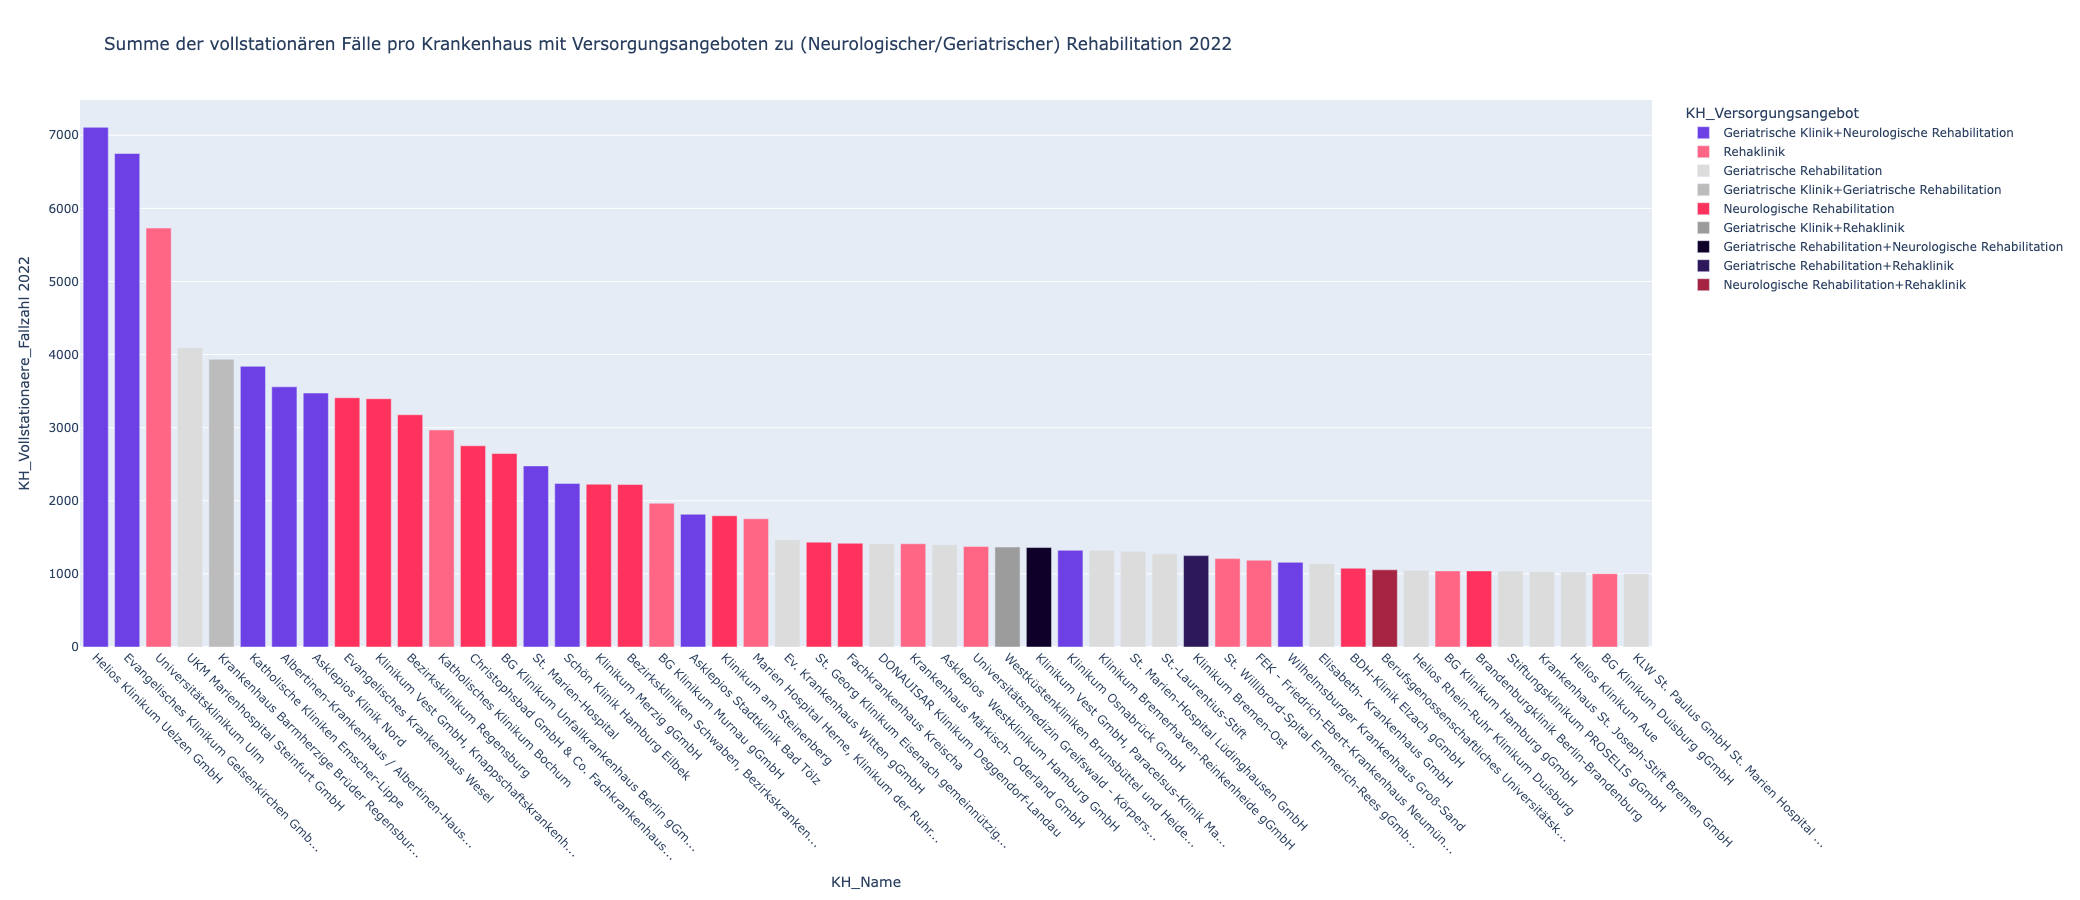

In [103]:
# Define the color mapping for the KH_Versorgungsangebot categories
color_map = {
    'Geriatrische Klinik': '#fcfcfc',    
    'Geriatrische Rehabilitation': '#dcdcdc',
    'Geriatrische Klinik+Geriatrische Rehabilitation': '#bcbcbc',
    'Geriatrische Klinik+Rehaklinik': '#9c9c9c',
    'Geriatrische Klinik+Neurologische Rehabilitation': '#6D40E6',
    'Geriatrische Rehabilitation+Rehaklinik': '#2d185c',
    'Geriatrische Rehabilitation+Neurologische Rehabilitation': '#0e0029',   
    'Rehaklinik': '#ff6585',
    'Neurologische Rehabilitation': '#ff325d',
    'Neurologische Rehabilitation+Rehaklinik': '#A52442'
    # Add other mappings as needed
}

# Function to truncate labels
def truncate_label(label, max_length=40):
    return label if len(label) <= max_length else label[:max_length] + '...'

# Filter to top 50 accounts
no_geri = no_geri.nlargest(50, 'KH_Vollstationaere_Fallzahl')

# Apply the function to the KH_Name column to create truncated labels
no_geri['KH_Name_Truncated'] = no_geri['KH_Name'].apply(lambda x: truncate_label(x))


# Apply the color mapping to a new column in the DataFrame
no_geri['color'] = no_geri['KH_Versorgungsangebot'].map(color_map)
# pivot_df
# Create the bar chart
fig = px.bar(
    no_geri, 
    x='KH_Name_Truncated', 
    y='KH_Vollstationaere_Fallzahl', 
    color='KH_Versorgungsangebot', 
    color_discrete_map=color_map,
    title='Summe der vollstationären Fälle pro Krankenhaus mit Versorgungsangeboten zu (Neurologischer/Geriatrischer) Rehabilitation 2022'
)

# Update layout for better readability
fig.update_layout(
    xaxis_title='KH_Name',
    yaxis_title='KH_Vollstationaere_Fallzahl 2022',
    legend_title='KH_Versorgungsangebot',
    height=900,
    width=1800,
    xaxis={
        'categoryorder': 'total descending',  # Optional: order categories by total y values
        'tickangle': 45  # Rotate x-axis labels by 45 degrees
    },
)

# Show the plot
fig.show()

In [106]:
import pydeck as pdk

max_data_value = no_geri["KH_Vollstationaere_Fallzahl"].max()
no_geri["Fallzahl_Relativ"] = (no_geri["KH_Vollstationaere_Fallzahl"] / max_data_value)
# charset = set(chain.from_iterable(no_geri.Unit.values.tolist()))

pydeck_layers = []
pydeck_layers.append(
    pdk.Layer(
        "ColumnLayer",
        data=no_geri,
        get_position="[Longitude, Latitude]",
        get_elevation="Fallzahl_Relativ",
        elevation_scale=100000,
        radius=1000,
        get_fill_color=[
            "Fallzahl_Relativ * 255",
            "(1. - Fallzahl_Relativ) * 255",
            "(1. - (2*Fallzahl_Relativ - 1.)^2) * 64",
            186,
        ],
        auto_highlight=True,
        pickable=True,
        extruded=True,
        coverage=1,
        # offset=[250, 0],
    )
)

pdk.Deck(
            map_style=None,
            initial_view_state=pdk.ViewState(
                # center of Germany: https://en.wikipedia.org/wiki/Central_Germany_(geography)
                latitude=51.163375,
                longitude=10.447683,
                zoom=6,
                pitch=50,
                height="90vh",
            ),
            tooltip={
                "html": "<b>{KH_Name}</b>: {KH_Vollstationaere_Fallzahl} F&auml;lle.",
                "style": {
                    "background": "grey",
                    "color": "white",
                    "font-family": '"Helvetica Neue", Arial',
                    "z-index": "10000",
                },
            },
            layers=pydeck_layers,
        )

{
  "initialViewState": {
    "height": "90vh",
    "latitude": 51.163375,
    "longitude": 10.447683,
    "pitch": 50,
    "zoom": 6
  },
  "layers": [
    {
      "@@type": "ColumnLayer",
      "autoHighlight": true,
      "coverage": 1,
      "data": [
        {
          "Bundesland": "Niedersachsen",
          "Fallzahl_Relativ": 1.0,
          "Hausnummer": "34",
          "IK": "260330793",
          "KH_Name": "Helios Klinikum Uelzen GmbH",
          "KH_Name_Truncated": "Helios Klinikum Uelzen GmbH",
          "KH_Versorgungsangebot": "Geriatrische Klinik+Neurologische Rehabilitation",
          "KH_Vollstationaere_Fallzahl": 7108,
          "Latitude": 52.97330495,
          "Longitude": 10.53257114477709,
          "Postleitzahl": "29525",
          "Strasse": "Hagenskamp",
          "color": "#6D40E6"
        },
        {
          "Bundesland": "Nordrhein-Westfalen",
          "Fallzahl_Relativ": 0.949634214969049,
          "Hausnummer": "27",
          "IK": "260550119",
          "KH_Name": "Evangelisches Klinikum Gelsenkirchen GmbH",
          "KH_Name_Truncated": "Evangelisches Klinikum Gelsenkirchen Gmb...",
          "KH_Versorgungsangebot": "Geriatrische Klinik+Neurologische Rehabilitation",
          "KH_Vollstationaere_Fallzahl": 6750,
          "Latitude": 51.50963915,
          "Longitude": 7.088762640163928,
          "Postleitzahl": "45879",
          "Strasse": "Munckelstr.",
          "color": "#6D40E6"
        },
        {
          "Bundesland": "Baden-W\u00fcrttemberg",
          "Fallzahl_Relativ": 0.8061339335959482,
          "Hausnummer": "29",
          "IK": "260840200",
          "KH_Name": "Universit\u00e4tsklinikum Ulm",
          "KH_Name_Truncated": "Universit\u00e4tsklinikum Ulm",
          "KH_Versorgungsangebot": "Rehaklinik",
          "KH_Vollstationaere_Fallzahl": 5730,
          "Latitude": 48.42262085,
          "Longitude": 9.948483609532069,
          "Postleitzahl": "89081",
          "Strasse": "Albert-Einstein-Allee",
          "color": "#ff6585"
        },
        {
          "Bundesland": "Nordrhein-Westfalen",
          "Fallzahl_Relativ": 0.5758300506471581,
          "Hausnummer": "1",
          "IK": "260500620",
          "KH_Name": "UKM Marienhospital Steinfurt GmbH",
          "KH_Name_Truncated": "UKM Marienhospital Steinfurt GmbH",
          "KH_Versorgungsangebot": "Geriatrische Rehabilitation",
          "KH_Vollstationaere_Fallzahl": 4093,
          "Latitude": 51.9625101,
          "Longitude": 7.6251879,
          "Postleitzahl": "48149",
          "Strasse": "Albert-Schweitzer-Campus Geb\u00e4ude D5",
          "color": "#dcdcdc"
        },
        {
          "Bundesland": "Bayern",
          "Fallzahl_Relativ": 0.5536015756893641,
          "Hausnummer": "86",
          "IK": "260930050",
          "KH_Name": "Krankenhaus Barmherzige Br\u00fcder Regensburg",
          "KH_Name_Truncated": "Krankenhaus Barmherzige Br\u00fcder Regensbur...",
          "KH_Versorgungsangebot": "Geriatrische Klinik+Geriatrische Rehabilitation",
          "KH_Vollstationaere_Fallzahl": 3935,
          "Latitude": 49.01585195,
          "Longitude": 12.064152995645454,
          "Postleitzahl": "93049",
          "Strasse": "Pr\u00fcfeninger Str.",
          "color": "#bcbcbc"
        },
        {
          "Bundesland": "Nordrhein-Westfalen",
          "Fallzahl_Relativ": 0.5400956668542487,
          "Hausnummer": "1",
          "IK": "260550621",
          "KH_Name": "Katholische Kliniken Emscher-Lippe",
          "KH_Name_Truncated": "Katholische Kliniken Emscher-Lippe",
          "KH_Versorgungsangebot": "Geriatrische Klinik+Neurologische Rehabilitation",
          "KH_Vollstationaere_Fallzahl": 3839,
          "Latitude": 51.57477675,
          "Longitude": 6.98730165747579,
          "Postleitzahl": "45964",
          "Strasse": "Barbarastra\u00dfe",
          "color": "#6D40E6"
        },
        {
          "Bundesland": "Deutschland",
          "Fallzahl_Relativ": 0

In [19]:
import folium
# add marker one by one on the map

# Make an empty map
m = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=5)

for i in range(0,len(no_geri)):
   folium.Marker(
      location=[no_geri.iloc[i]['Latitude'], no_geri.iloc[i]['Longitude']],
      popup=no_geri.iloc[i]['KH_Name'],
   ).add_to(m)

# Show the map again
m

Vorhaben:
Eine Funktion, die dasselbe Schema unabhängig von der Suche nach FA, ICD oder OPS ausgibt, damit man am Ende einen Union machen kann


### Betrachtung nach ICD-10 Codes

In [107]:
# pivot_df = pivot_df[['IK', 'KH_Name', 'Strasse', 'Hausnummer', 'Postleitzahl', 'Bundesland', 'Latitude', 'Longitude', 'KH_Versorgungsangebot', 'KH_Vollstationaere_Fallzahl']].copy()
pivot_df = pivot_df[['IK', 'KH_Name', 'KH_Versorgungsangebot', 'KH_Vollstationaere_Fallzahl']].copy()

pivot_df

,IK,KH_Name,KH_Versorgungsangebot,KH_Vollstationaere_Fallzahl
0,260100034,Malteser Krankenhaus St. Franziskus-Hospital,Geriatrische Klinik,1562
1,260100476,Klinikum Nordfriesland gGmbH,Geriatrische Klinik,1076
2,260100626,AMEOS Krankenhausgesellschaft Ostholstein mbH,Geriatrische Klinik,1101
3,260100626,AMEOS Krankenhausgesellschaft mbH,Geriatrische Klinik,581
4,260100682,Sankt Elisabeth Krankenhaus Eutin,Geriatrische Klinik,1631
...,...,...,...,...
486,261601021,HELIOS Klinikum Erfurt,Geriatrische Klinik,1859
487,261601032,MEDIAN Heinrich-Mann-Klinik,Neurologische Rehabilitation,189
488,261601123,St. Georg Klinikum Eisenach gemeinnützige GmbH,Neurologische Rehabilitation,1434
489,261601145,KMG Klinikum Sondershausen,Geriatrische Klinik,551


In [89]:
def get_icd10_kh() -> pd.DataFrame:
    df = run_sql(       
            f"""SELECT
            IK,
            Name AS KH_Name,
            Strasse,
           	Hausnummer,
           	Postleitzahl,
           	geo_Bundesland AS Bundesland,
           	AVG(DISTINCT geo_Lat) AS Latitude,
           	AVG(DISTINCT geo_Lon) AS Longitude,
            SUM(Fallzahl) AS ICD10_Fallzahl_Total
        FROM
            VIEW_Krankenhaus_Hauptdiagnosen
        WHERE 
        (Berichtsjahr = 2022) 
        AND 
        (ICD_10 IN ('I21.1', 'I21.2', 'I21.3', 'I21.4', 'I21.9', 'I22', 'I22.0', 'I22.1', 'I22.8', 'I22.9', 'I23', 'I23.0',
        'I23.1', 'I23.2', 'I23.3', 'I23.4', 'I23.5', 'I23.6', 'I23.8', 'I24.0', 'I24.1', 'I63', 'I63.0', 'I63.1', 'I63.2', 'I63.3', 'I63.4',
        'I63.5', 'I63.6', 'I63.8', 'I63.9', 'I64', 'I69', 'I69.0', 'I69.1', 'I69.2', 'I69.3', 'I69.4'))
        GROUP BY
            Berichtsjahr,
            IK,
            Name
        ORDER BY
            ICD10_Fallzahl_Total DESC
        ;"""
    )
    return df

df = get_icd10_kh()
df["ICD10_Fallzahl_Total"].fillna(0, inplace=True)

df

,IK,KH_Name,Strasse,Hausnummer,Postleitzahl,Bundesland,Latitude,Longitude,ICD10_Fallzahl_Total
0,261101878,Vivantes - Netzwerk für Gesundheit GmbH,Aroser Allee,72-76,13407,Deutschland,52.564097,13.353412,4849.0
1,261101015,Charité - Universitätsmedizin Berlin,Charitéplatz,1,10117,Deutschland,52.525852,13.377758,2579.0
2,260102343,UNIVERSITÄTSKLINIKUM Schleswig-Holstein,Ratzeburger Allee,160,23562,Schleswig-Holstein,53.850141,10.694166,2572.0
3,260970015,Universitätsklinikum Augsburg A.ö.R.,Stenglinstr.,2,86156,Bayern,48.384517,10.838076,2093.0
4,260820466,Universitätsklinikum Heidelberg,Im Neuenheimer Feld,672,69120,Baden-Württemberg,49.417134,8.664529,1920.0
...,...,...,...,...,...,...,...,...,...
1234,261600371,HELIOS Klinik Blankenhain,Wirthstraße,5,99444,Thüringen,50.860054,11.339276,0.0
1235,261601010,Eichsfeld Klinikum gGmbh,Im Kloster,7,37355,Thüringen,51.347391,10.363526,0.0
1236,269715058,Klinik Donaustauf,Ludwigstrasse,68,93093,Bayern,49.036669,12.208155,0.0
1237,269719007,LungenClinic Grosshansdorf,Wöhrendamm,80,22927,Schleswig-Holstein,53.660475,10.281092,0.0


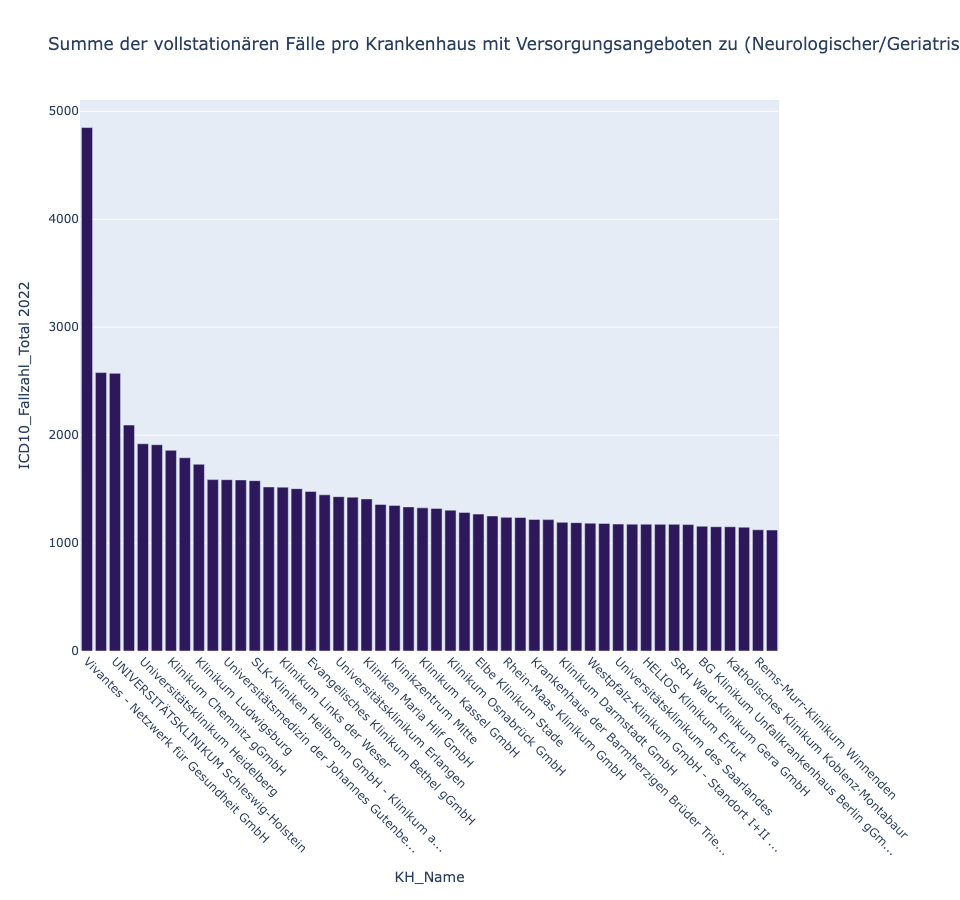

In [90]:
# Function to truncate labels
def truncate_label(label, max_length=40):
    return label if len(label) <= max_length else label[:max_length] + '...'

# Filter to top 50 accounts
df_bar = df.nlargest(50, 'ICD10_Fallzahl_Total')

# Apply the function to the KH_Name column to create truncated labels
df_bar['KH_Name_Truncated'] = df_bar['KH_Name'].apply(lambda x: truncate_label(x))

# Create the bar chart
fig2 = px.bar(
    df_bar, 
    x='KH_Name_Truncated', 
    y='ICD10_Fallzahl_Total',
    title='Summe der vollstationären Fälle pro Krankenhaus mit Versorgungsangeboten zu (Neurologischer/Geriatrischer) Rehabilitation 2022'
)
fig2.update_traces(marker_color='#2d185c')
# Update layout for better readability
fig2.update_layout(
    xaxis_title='KH_Name',
    yaxis_title='ICD10_Fallzahl_Total 2022',
    height=900,
    width=1200,
    xaxis={
        'categoryorder': 'total descending',  # Optional: order categories by total y values
        'tickangle': 45  # Rotate x-axis labels by 45 degrees
    },
)

# Show the plot
fig2.show()

In [91]:
# df1.merge(df2, how='inner', on='a')

sdf = df.merge(pivot_df, how='outer', on=['IK', 'KH_Name'])
#'IK', 'KH_Name', 'Strasse', 'Hausnummer', 'Postleitzahl', 'Bundesland', 'Latitude', 'Longitude'
sdf

,IK,KH_Name,Strasse,Hausnummer,Postleitzahl,Bundesland,Latitude,Longitude,ICD10_Fallzahl_Total,KH_Versorgungsangebot,KH_Vollstationaere_Fallzahl
0,261101878,Vivantes - Netzwerk für Gesundheit GmbH,Aroser Allee,72-76,13407,Deutschland,52.564097,13.353412,4849.0,Geriatrische Klinik,8628.0
1,261101015,Charité - Universitätsmedizin Berlin,Charitéplatz,1,10117,Deutschland,52.525852,13.377758,2579.0,Geriatrische Klinik,400.0
2,260102343,UNIVERSITÄTSKLINIKUM Schleswig-Holstein,Ratzeburger Allee,160,23562,Schleswig-Holstein,53.850141,10.694166,2572.0,NaN,NaN
3,260970015,Universitätsklinikum Augsburg A.ö.R.,Stenglinstr.,2,86156,Bayern,48.384517,10.838076,2093.0,NaN,NaN
4,260820466,Universitätsklinikum Heidelberg,Im Neuenheimer Feld,672,69120,Baden-Württemberg,49.417134,8.664529,1920.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1241,269715058,Klinik Donaustauf,Ludwigstrasse,68,93093,Bayern,49.036669,12.208155,0.0,NaN,NaN
1242,269719007,LungenClinic Grosshansdorf,Wöhrendamm,80,22927,Schleswig-Holstein,53.660475,10.281092,0.0,NaN,NaN
1243,510106392,Katharinen Hospiz am Park,Mühlenstraße,1,24937,Schleswig-Holstein,54.786451,9.427458,0.0,NaN,NaN
1244,260510791,AMEOS Klinikum St. Marien Oberhausen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Geriatrische Klinik,4.0


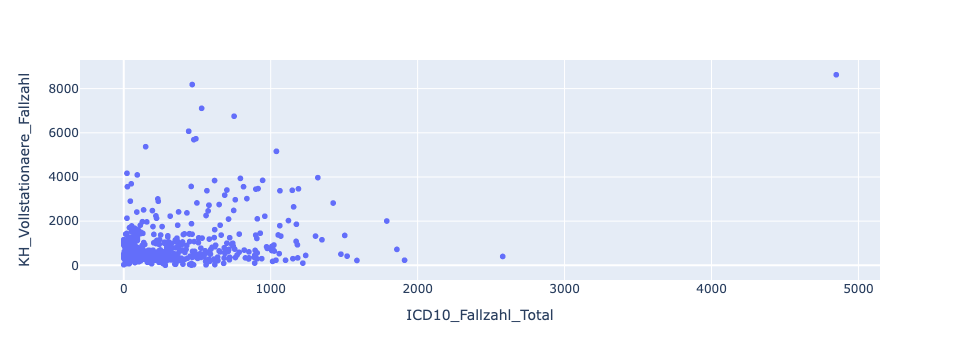

In [92]:
fig4 = px.scatter(sdf, x="ICD10_Fallzahl_Total", y="KH_Vollstationaere_Fallzahl")
fig4.show()

In [33]:
import pandas as pd
import plotly.express as px
import plotly.subplots as sp

# Step 2: Pivot the data to get counts
pivot_df = pd.crosstab([df['IK'], df['KH_Name'], df['Strasse'], df['Hausnummer'], df['Postleitzahl'], df['Bundesland'],df['Latitude'],  df['Longitude']], df['FA_Versorgungsangebot'], rownames=['IK', 'KH_Name', 'Strasse', 'Hausnummer', 'Postleitzahl', 'Bundesland', 'Latitude', 'Longitude'], colnames=['FA_Versorgungsangebot'])
# pivot_df = pd.crosstab([df['IK'], df['KH_Name']], df['FA_Versorgungsangebot'], rownames=['IK','KH_Name'], colnames=['FA_Versorgungsangebot'])

# Step 3: Add the "combination" column
pivot_df['KH_Versorgungsangebot'] = pivot_df.apply(lambda row: '+'.join(row.index[row.astype(bool)]), axis=1)

# Step 4: Compute the sum of 'number' for each group
number_sums = df.groupby('KH_Name')['ICD10_Fallzahl_Total'].sum()

# Merge the sum back into the pivot DataFrame
pivot_df = pivot_df.merge(number_sums, left_index=True, right_index=True)

# Reset the index to turn the index back into a column
pivot_df = pivot_df.reset_index()

# Rename columns for clarity
pivot_df = pivot_df.rename(columns={'ICD10_Fallzahl_Total': 'Summe_ICD10_Fallzahl_Total'})
# pivot_df[pivot_df['KH_Name'].isin(["Städtisches Krankenhaus Eisenhüttenstadt GmbH"])]
# pivot_df[pivot_df['KH_Name'].isin(["Gemeinschaftsklinikum Mittelrhein gGmbH"])]
pivot_df

no_geri = pivot_df[pivot_df['KH_Versorgungsangebot'].isin(['Rehaklinik',
       'Geriatrische Klinik+Rehaklinik',
       'Geriatrische Klinik+Neurologische Rehabilitation',
       'Geriatrische Rehabilitation', 'Neurologische Rehabilitation',
       'Geriatrische Rehabilitation+Rehaklinik',
       'Geriatrische Rehabilitation+Neurologische Rehabilitation',
       'Neurologische Rehabilitation+Rehaklinik',
       'Geriatrische Klinik+Geriatrische Rehabilitation'])]
no_geri.reset_index(inplace=True, drop=True)
no_geri = no_geri[['IK', 'KH_Name', 'Strasse', 'Hausnummer', 'Postleitzahl', 'Bundesland', 'Latitude', 'Longitude', 'KH_Versorgungsangebot', 'Summe_ICD10_Fallzahl_Total']].copy()
no_geri

,IK,KH_Name,Strasse,Hausnummer,Postleitzahl,Bundesland,Latitude,Longitude,KH_Versorgungsangebot,Summe_ICD10_Fallzahl_Total
0,260101488,FEK - Friedrich-Ebert-Krankenhaus Neumünster GmbH,Friesenstraße,11,24534,Schleswig-Holstein,54.065267,9.992990,Rehaklinik,120.0
1,260200024,Asklepios Klinik St. Georg,Lohmühlenstr.,5,20099,Deutschland,53.559245,10.017431,Rehaklinik,21.0
2,260200046,Schön Klinik Hamburg Eilbek,Dehnhaide,120,22081,Deutschland,53.578396,10.052161,Neurologische Rehabilitation,92.0
3,260200091,Asklepios Westklinikum Hamburg GmbH,Suurheid,20,22559,Deutschland,53.581594,9.780228,Geriatrische Rehabilitation,69.0
4,260200171,Albertinen-Krankenhaus / Albertinen-Haus gemei...,Süntelstraße,11a,22457,Deutschland,53.631363,9.904322,Geriatrische Klinik+Neurologische Rehabilitation,546.0
...,...,...,...,...,...,...,...,...,...,...
86,261460010,Neurologisches Fachkrankenhaus Zscheckwitz,Ortsteil Zscheckwitz,1-3,01731,Sachsen,50.945373,13.760102,Neurologische Rehabilitation,0.0
87,261460021,Fachkrankenhaus Kreischa,An der Wolfsschlucht,1-2,01731,Sachsen,50.946615,13.769070,Neurologische Rehabilitation,81.0
88,261460076,ELBLAND Rehabilitationsklinik Großenhain,Am Bobersberg,4,01558,Sachsen,51.287199,13.539277,Neurologische Rehabilitation,216.0
89,261500553,BG Klinikum Bergmannstrost Halle,Merseburger Straße,165,06112,Sachsen-Anhalt,51.460224,11.986571,Rehaklinik,31.0


# Backup

In [34]:
unique_combinations = no_geri['KH_Versorgungsangebot'].unique()
unique_combinations

array(['Rehaklinik', 'Neurologische Rehabilitation',
       'Geriatrische Rehabilitation',
       'Geriatrische Klinik+Neurologische Rehabilitation',
       'Geriatrische Rehabilitation+Rehaklinik',
       'Geriatrische Rehabilitation+Neurologische Rehabilitation',
       'Geriatrische Klinik+Geriatrische Rehabilitation',
       'Geriatrische Klinik+Rehaklinik'], dtype=object)

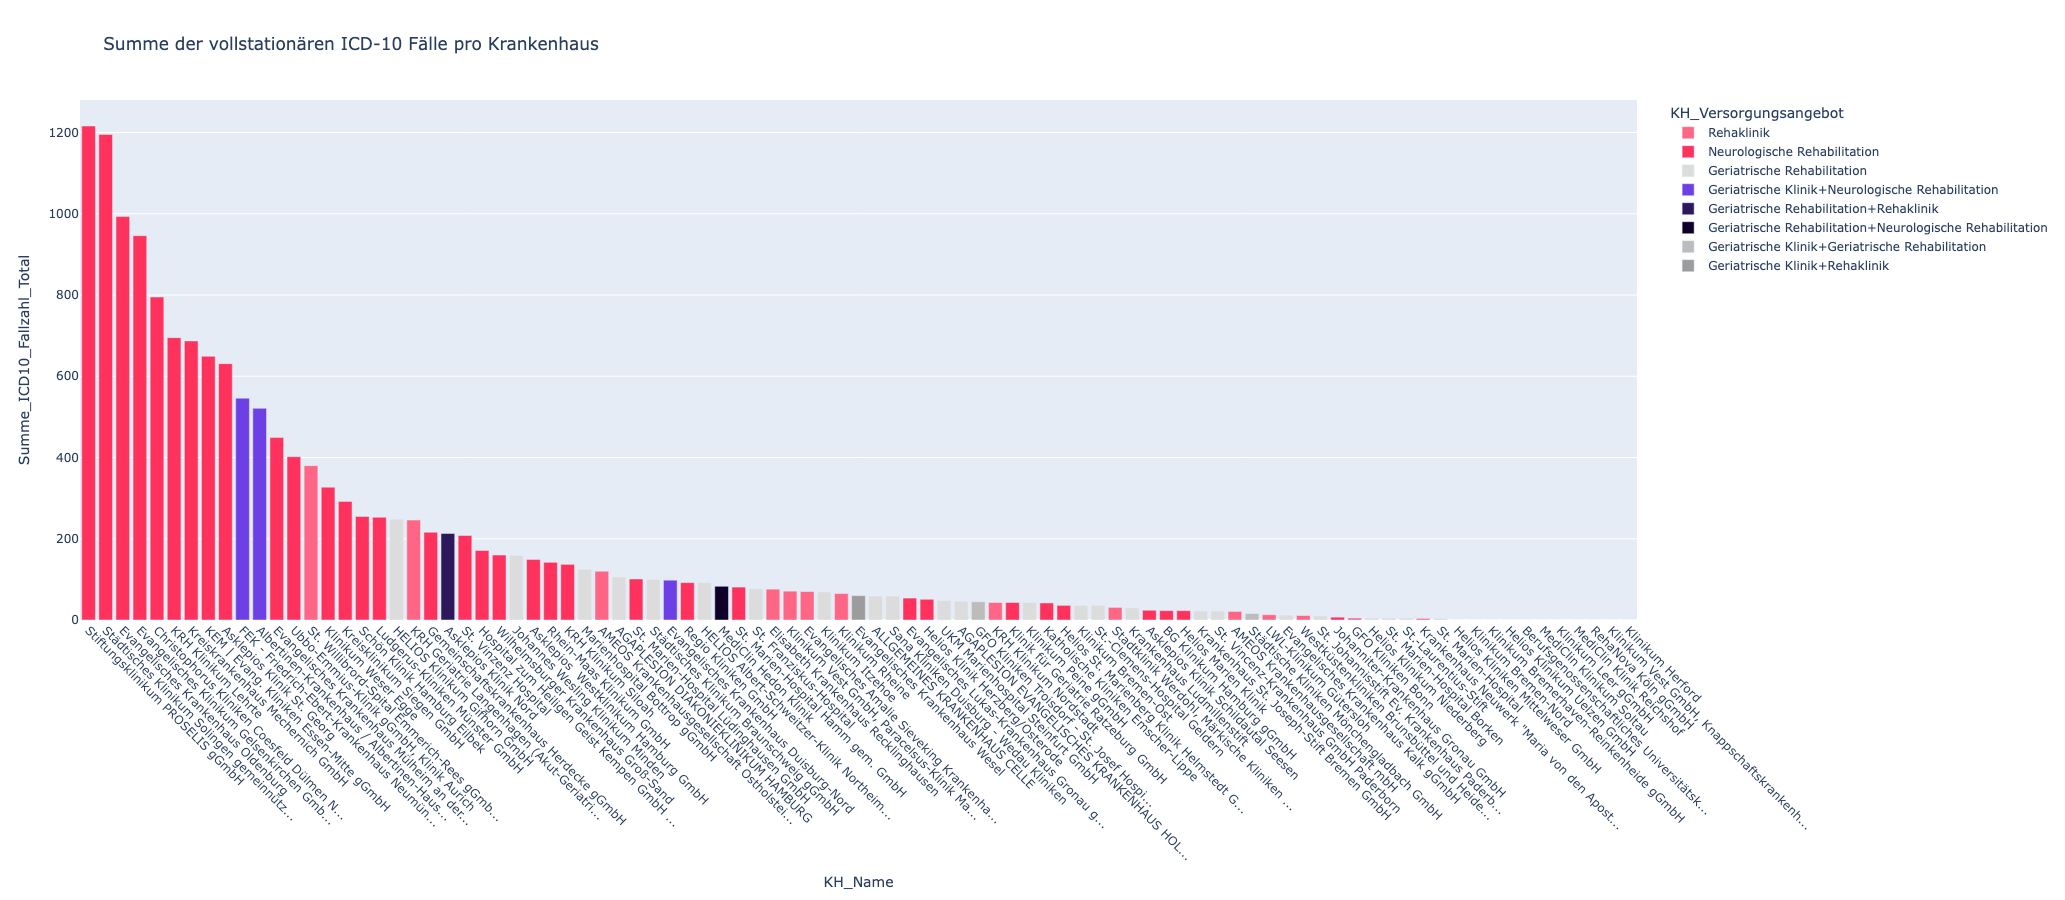

In [35]:
# Define the color mapping for the KH_Versorgungsangebot categories
color_map = {
    'Geriatrische Klinik': '#fcfcfc',    
    'Geriatrische Rehabilitation': '#dcdcdc',
    'Geriatrische Klinik+Geriatrische Rehabilitation': '#bcbcbc',
    'Geriatrische Klinik+Rehaklinik': '#9c9c9c',
    'Geriatrische Klinik+Neurologische Rehabilitation': '#6D40E6',
    'Geriatrische Rehabilitation+Rehaklinik': '#2d185c',
    'Geriatrische Rehabilitation+Neurologische Rehabilitation': '#0e0029',   
    'Rehaklinik': '#ff6585',
    'Neurologische Rehabilitation': '#ff325d',
    'Neurologische Rehabilitation+Rehaklinik': '#A52442'
    # Add other mappings as needed
}

# Function to truncate labels
def truncate_label(label, max_length=40):
    return label if len(label) <= max_length else label[:max_length] + '...'

# Apply the function to the KH_Name column to create truncated labels
no_geri['KH_Name_Truncated'] = pivot_df['KH_Name'].apply(lambda x: truncate_label(x))


# Apply the color mapping to a new column in the DataFrame
no_geri['color'] = no_geri['KH_Versorgungsangebot'].map(color_map)
# pivot_df
# Create the bar chart
fig = px.bar(
    no_geri, 
    x='KH_Name_Truncated', 
    y='Summe_ICD10_Fallzahl_Total', 
    color='KH_Versorgungsangebot', 
    color_discrete_map=color_map,
    title='Summe der vollstationären ICD-10 Fälle pro Krankenhaus'
)

# Update layout for better readability
fig.update_layout(
    xaxis_title='KH_Name',
    yaxis_title='Summe_ICD10_Fallzahl_Total',
    legend_title='KH_Versorgungsangebot',
    height=900,
    width=1800,
    xaxis={
        'categoryorder': 'total descending',  # Optional: order categories by total y values
        'tickangle': 45  # Rotate x-axis labels by 45 degrees
    },
)

# Show the plot
fig.show()

In [28]:
def get_icd10_fa() -> pd.DataFrame:
    df = run_sql(       
            f"""SELECT
        IK,
        Name AS KH_Name,
        Strasse,
       	Hausnummer,
       	Postleitzahl,
       	geo_Bundesland AS Bundesland,
       	geo_Lat AS Latitude,
       	geo_Lon AS Longitude,
        SUM(Fallzahl) AS ICD10_Fallzahl_Total,
        Name_OE AS FA_Name,
    CASE	    
	    WHEN Name_OE like '%neurolog%reha%' then 'Neurologische Rehabilitation'
	    WHEN Name_OE like '%geriatri%reha%' then 'Geriatrische Rehabilitation'
    	WHEN Name_OE like '%reha%' then 'Rehaklinik'
    	WHEN Name_OE like '%geriatri%' then 'Geriatrische Klinik'
	end as FA_Versorgungsangebot
    FROM
        VIEW_Krankenhaus_Hauptdiagnosen
    WHERE 
    (Berichtsjahr = 2022)
    AND 
    (ICD_10 IN ('I21.1', 'I21.2', 'I21.3', 'I21.4', 'I21.9', 'I22', 'I22.0', 'I22.1', 'I22.8', 'I22.9', 'I23', 'I23.0',
    'I23.1', 'I23.2', 'I23.3', 'I23.4', 'I23.5', 'I23.6', 'I23.8', 'I24.0', 'I24.1', 'I63', 'I63.0', 'I63.1', 'I63.2', 'I63.3', 'I63.4',
    'I63.5', 'I63.6', 'I63.8', 'I63.9', 'I64', 'I69', 'I69.0', 'I69.1', 'I69.2', 'I69.3', 'I69.4'))
    AND
    (Name_OE like '%neurolog%reha%'
    OR 
    Name_OE like '%geriatri%reha%'
    OR 
    Name_OE like '%reha%'
    OR 
    Name_OE like '%geriatri%')
    GROUP BY
    Berichtsjahr,
    Name_OE 
    ;"""
    )
    return df

df = get_icd10_kh()
df["ICD10_Fallzahl_Total"].fillna(0, inplace=True)

df

,IK,KH_Name,Strasse,Hausnummer,Postleitzahl,Bundesland,Latitude,Longitude,ICD10_Fallzahl_Total,FA_Name,FA_Versorgungsangebot
0,260340034,"Ubbo-Emmius-Klinik gGmbH, Klinik Aurich",Wallinghausener Str. 8 - 12,8 - 12,26603,Niedersachsen,53.469560,7.482381,4.0,Abteilung für Akut-Geriatrie,Geriatrische Klinik
1,260200091,Asklepios Westklinikum Hamburg GmbH,Suurheid,20,22559,Deutschland,53.581594,9.780228,69.0,Abteilung für Akutgeriatrie und Frührehabilita...,Geriatrische Rehabilitation
2,260510973,St. Willibrord-Spital Emmerich-Rees gGmbH,Willibrordstraße,9,46446,Nordrhein-Westfalen,51.832737,6.239207,43.0,Abteilung für Altersmedizin und Frührehabilita...,Rehaklinik
3,260590037,Berufsgenossenschaftliches Universitätskliniku...,Bürkle-de-la-Camp-Platz,1,44789,Nordrhein-Westfalen,51.468494,7.212307,0.0,Abteilung für BG Rehabilitation,Rehaklinik
4,260200024,Asklepios Klinik St. Georg,Lohmühlenstr.,5,20099,Deutschland,53.559245,10.017431,21.0,Abteilung für Frührehabilitation,Rehaklinik
...,...,...,...,...,...,...,...,...,...,...,...
245,260100739,Regio Kliniken GmbH,Ramskamp,71-75,25337,Schleswig-Holstein,53.741358,9.699612,89.0,Zentrum für Innere Medizin - Klinik für Geriat...,Geriatrische Klinik
246,260100739,Regio Kliniken GmbH,Ramskamp,71-75,25337,Schleswig-Holstein,53.741358,9.699612,0.0,Zentrum für Innere Medizin - Klinik für Geriat...,Geriatrische Klinik
247,260620271,Klinikum Bad Hersfeld GmbH,Seilerweg,29,36251,Hessen,50.875943,9.713436,51.0,Zentrum für Klinische Geriatrie,Geriatrische Klinik
248,260950055,Klinikum am Europakanal,Am Europakanal,71,91056,Bayern,49.605933,10.969543,142.0,Zentrum für Neurologie und Neurologische Rehab...,Neurologische Rehabilitation


In [ ]:
### Sum over ICD-10 Cases with the ability to group by regional areas, cities, or hospitals --> no hospital granularity available in this view
def get_sum_icd10_geo(group_by: str, where: str = "") -> pd.DataFrame:
    df = run_sql(       
            f"""SELECT
        {group_by} AS Unit,
        Berichtsjahr,
        SUM(Fallzahl) AS Fallzahl_Total,
        AVG(DISTINCT geo_Lat) AS Latitude,
        AVG(DISTINCT geo_Lon) AS Longitude
    FROM
        VIEW_Krankenhaus_Hauptdiagnosen
    {where}
    GROUP BY
        Berichtsjahr,
        {group_by}
    ORDER BY
        Fallzahl_Total DESC
    ;"""
        )
    df["Fallzahl_Total_Text"] = (
        df["Fallzahl_Total"].fillna(-1).astype(int).astype(str).replace("-1", "< 4")
    )
    df["Fallzahl_Total"].fillna(0, inplace=True)
    df["Unit_HTML"] = df["Unit"].apply(lambda x: html.escape(x))
    return df


sql_filter_list = "'C57', 'C65'"
group='Name'

icd10_data = get_sum_icd10_geo(
    group_by=group,
    where=f'WHERE (ICD_10 IN ({sql_filter_list})) AND (Berichtsjahr = 2022)',
)
icd10_data
# year = '2022'
# bb = icd10_data[icd10_data["Berichtsjahr"] == year].copy()

# bb

### Sum over ICD-10 Cases strictly on hospital level 
def get_sum_icd10_kh(columns: str = "", where: str = "") -> pd.DataFrame:
    df = run_sql(       
            f"""SELECT
        Berichtsjahr,
        IK,
        SUBSTR(IK, 0, 3) AS KH_Type,
        {columns},
        SUM(Fallzahl) AS Fallzahl_Total,
        AVG(DISTINCT geo_Lat) AS Latitude,
        AVG(DISTINCT geo_Lon) AS Longitude
    FROM
        VIEW_Krankenhaus_Hauptdiagnosen
    {where}
    GROUP BY
        Berichtsjahr,
        IK
    ORDER BY
        KH_Type DESC
    ;"""
        )
    df["Fallzahl_Total_Text"] = (
        df["Fallzahl_Total"].fillna(-1).astype(int).astype(str).replace("-1", "< 4")
    )
    df["Fallzahl_Total"].fillna(0, inplace=True)
    df["KH_Type_html"] = df["KH_Type"].apply(lambda x: html.escape(x))
    return df


columns="Name, Anzahl_Betten, Vollstationaere_Fallzahl, Teilstationaere_Fallzahl, Ambulante_Fallzahl, StaeB_Fallzahl, Strasse, Hausnummer, Postleitzahl"

icd10_kh_type = get_sum_icd10_kh(
    columns=columns,
    where=f"""WHERE (ICD_10 IN ({sql_filter_list})) AND (Berichtsjahr = 2022)""",
)
icd10_kh_type
# year = '2022'
# bb = icd10_data[icd10_data["Berichtsjahr"] == year].copy()

# bb

In [ ]:
### [ICD-10 QUERY] This is the most generic query which allows to append data regardless of ICD-10 or OPS-301 codes --> hospitals are only identified by their IK and name; any additional analyses happen at a later point
def get_sum_icd10_kh(group_by: str, where: str = "") -> pd.DataFrame:
    df = run_sql(       
            f"""SELECT
        Berichtsjahr,
        IK,
        Name,
        SUM(Fallzahl) AS Fallzahl_Total,
        AVG(DISTINCT geo_Lat) AS Latitude,
        AVG(DISTINCT geo_Lon) AS Longitude
    FROM
        VIEW_Krankenhaus_Hauptdiagnosen
    {where}
    GROUP BY
        Berichtsjahr,
        IK
    ORDER BY
        Fallzahl_Total DESC
    ;"""
        )
    df["Fallzahl_Total_Text"] = (
        df["Fallzahl_Total"].fillna(-1).astype(int).astype(str).replace("-1", "< 4")
    )
    df["Fallzahl_Total"].fillna(0, inplace=True)
    return df

icd10_per_fa = get_ik(where=f"""WHERE Berichtsjahr = 2022""")
# kh_type = get_ik(where=f"""WHERE (Berichtsjahr = 2022) AND (type in ('51', '57', '59', '27'))""")
kh_type

In [ ]:
FILTER_COLUMNS = {
    "geo_Bundesland": "Bundesland",
    "geo_Landkreis": "Landkreis",
    "Postleitzahl": "Postleitzahl",
    "Ort": "Stadt",
    "Name": "Krankenhaus",
}